This notebook uses torch to train an LSTM to swingup, the advantage of using torch over keras is that we can more easily modify the implementation

In [1]:
import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML


import torch
import torch.nn as nn

# these are our own packages
from cartpole_class import Cartpole 
from torch_lstm_mod.router import Router

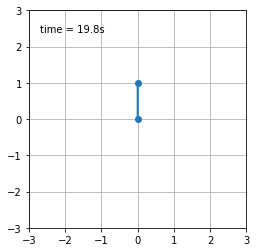

In [2]:
# time step
bot = Cartpole()

dt = 0.1
time = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 1
num_states = 4
num_t = len(time)
y = np.zeros((num_t, num_states, num_trials))


for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    xdot = 0.0

    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    u_hist = []
    y[:, :, i] = integrate.odeint(bot.derivs, state, time)



# clunky, but we get u after the fact
u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = bot.control(y[t,:,i]) 

        
ani = bot.animate_cart(time, y[:,:,0])
HTML(ani.to_jshtml())

In [4]:
#model = nn.LSTM(input_size = 4, hidden_size = 12, bias=True)
model = Router(input_size = 4, hidden_size = 12, output_size = 1, router_size = 12)

In [13]:
#out, hidden = model(torch.FloatTensor(y[:,:,0]).view(200,1,4),(torch.randn(1,1,12), torch.randn(1,1,12)))
ys, yb , d = model(torch.randn(1,4))
#out = model(ytr)

print(ys.shape)
print(yb.shape)
print(d.shape)
#print(hidden[0].shape)

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 2])


In [31]:
# Train LSTM



def select_action(x, policy):
    x = torch.from_numpy(x).float().unsqueeze(0)

    ys, yb, d = policy(x)
    m = torch.distributions.Categorical(d)
    path = m.sample()

    policy.saved_log_probs.append(m.log_prob(path))

    if path.item() == 0:
        return ys.item()
    else:
        return yb.item()

        
        
        
# Calculates the time weighted rewards, policy losses, and optimizers
def finish_episode(policy):
    R = 0
    policy_loss = []
    rewards = []

    gamma = .5
    for r in policy.rewards[::-1]:
        R = r + gamma*R
        rewards.append(R)

    rewards = rewards[::-1]
    rewards = torch.tensor(rewards)

    std = rewards.std()
    if torch.isnan(std):
        std = 1

    rewards = (rewards - rewards.mean())/(std + eps)

    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)

    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()

    del policy.rewards[:]
    del policy.saved_log_probs[:]

    
    

# very simple L2 loss
def criterion(upred, uactual):
    return (upred - uactual)**2


learning_rate = .005 
def train(y, u, model):
        
    for i, inp in enumerate(y):
        ys, yb, d = model(torch.Tensor(inp).view(1,4))
    
        loss_s = criterion(ys, torch.Tensor(u[i]))*d[0,0]
        loss_b = criterion(yb, torch.Tensor(u[i]))*d[0,1]
        
        loss_hist_s.append(loss_s)
        loss_hist_b.append(loss_b)
        
        torch.autograd.backward([loss_s, loss_b], retain_graph=True)
    
        for p in model.parameters():
            p.data.add_(-learning_rate, p.grad.data)

    return loss_s, loss_b
    

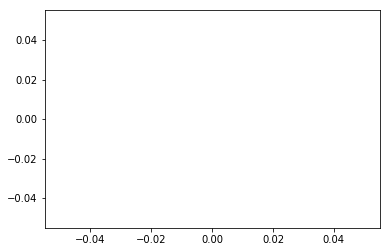

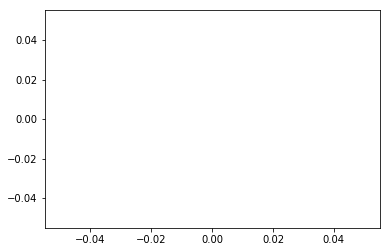

In [34]:
loss_hist_s = []
loss_hist_b = []
epochs = 5

for _ in range(epochs):
    loss_s, loss_b = train(y, u, model)
    loss_hist_s.append(loss_s)
    loss_hist_b.append(loss_b)


plt.plot(loss_hist_b)
plt.figure()
plt.plot(loss_hist_s)


In [ ]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q):
            return model.predict(q.reshape((1,4)))
        
    return nn_controller

control = make_controller(model)

In [ ]:
bot = Cartpole()

bot.control = control

# initial conditions
theta = 0
x = 5
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
time = np.arange(0.0, 20, dt)

# initial state
state = np.array([theta, x, th_dot, xdot])

In [ ]:
# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_simple = integrate.odeint(simple_bot.derivs, state, time)
u_simple = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_simple[t] = simple_bot.control(y[t]) 

        
data = np.concatenate((y_simple, u_simple),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = simple_bot.animate_cart(time, y_simple)
HTML(ani.to_jshtml())

plt.figure()
plt.plot(y_simple[:,2])

In [ ]:
# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_lstm = integrate.odeint(lstm_bot.derivs, state, time)
u_lstm = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_lstm[t] = lstm_bot.control(y[t]) 

        
data = np.concatenate((y_lstm, u_lstm),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = lstm_bot.animate_cart(time, y_lstm)
HTML(ani.to_jshtml())